Churn prediction
-------------------
Company churn occurs when companies cancel subscriptions or subscriptions expires without renewals.  
This notebook uses DecisionTree to predict Churn, and GridSearchCV to perform hyperparameter tuning.

**Note:**
- usage count >= 100

In [0]:
import mlflow
import mlflow.sklearn
from datetime import datetime

mlflow.set_experiment("/Users/bxing@actsoft.com/Churn/Imbalance/Churn_Imbalance_XGB_SHAP")

# date that license deactivation will check against in determinding churn or no-churn,
# usually the date that data storage was created.
pred_datetime = datetime(2020, 7, 21)
mlflow.log_param("End date", pred_datetime)

# start datetime for license activation.
start_dateime = datetime(2000, 1, 1)
mlflow.log_param("Start date", start_dateime)

# include both registered and non registered users
registered_only = False
mlflow.log_param("Setup complete", registered_only)

# over-sample minority and under-sample majority
over_sample = False 
under_sample = False
mlflow.log_param("over_sample", over_sample)
mlflow.log_param("under_sample", under_sample)

In [0]:
%run /Users/bxing@actsoft.com/Churn/Churn_Dataframe

More filtering before modeling

In [0]:
df = df[(df.Trips>=100) | (df.Forms>=100) | (df.Timekeeping>=100) | (df.Orders>=100)]
df.shape

Out[51]: (1936, 24)

Out[49]: (3515, 24)

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
0,822,50,Ward Alternative Energy,10,True,0,694,Ward Alternative Energy,Fort Collins,Colorado,80521,US,en-US,2016-01-21,2016-07-22,2016-09-10 13:06:06.760,233,1,9,85,2819,0,66,0
1,872,50,TECS ELECTRIC LTD,30,True,0,744,TECS ELECTRIC LTD,Weatherford,TX,76087,US,en-US,2016-01-27,2016-04-08,2016-09-10 13:06:21.940,227,1,43,0,0,5,4,624
2,1027,50,Hood River Taxi,10,True,0,899,Hood River Taxi,Hood River,Oregon,97031,US,en-US,2016-02-12,2016-04-04,2016-09-10 13:06:52.400,211,1,8,0,922,0,0,0
3,1107,50,AAA Signs Inc,10,True,0,979,AAA Signs Inc,Sacramento,California,95815,US,en-US,2016-03-04,2017-12-21,2017-12-21 00:13:54.140,657,1,34,0,16683,2,0,6
4,1478,50,Precious Ones Day Care,10,True,0,1340,Precious Ones Day Care,Bethlehem,Pennsylvania,None,US,en-US,2016-04-20,2019-06-22,2019-06-22 00:14:20.290,1158,1,5,0,0,0,2,0


In [0]:
df.describe(include='all')

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
count,1936.000000,1936.0,1936,1936.000000,1936,1936.0,1936.000000,1936,1773,1242,1718,1936,1936,1936,1658,1658,1936.000000,1936.000000,1936.000000,1936.000000,1.936000e+03,1.936000e+03,1936.000000,1936.000000
unique,NaN,NaN,1929,NaN,1,NaN,NaN,1924,1198,96,1474,1,1,959,873,1657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Midwest Mobility Solutions,NaN,True,NaN,NaN,CITY OF SAN ANTONIO,San Juan,CA,92626,US,en-US,2016-10-31 00:00:00,2018-11-30,2020-06-16 00:01:41.280000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3,NaN,1936,NaN,NaN,3,18,133,6,1936,1936,10,31,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-21 00:00:00,NaN,2016-09-10 13:04:45.280000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-25 00:00:00,NaN,2020-07-15 21:49:11.420000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9526.051653,50.0,NaN,16.282025,NaN,0.0,7982.231405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,551.513946,0.856405,67.392045,4.314050,8.934050e+04,1.293894e+04,801.741736,551.026860
std,7244.648999,0.0,NaN,7.709587,NaN,0.0,5175.709755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,387.483457,0.350769,1320.525788,24.061131,3.102167e+06,4.909980e+05,4459.145520,4101.155436
min,396.000000,50.0,NaN,2.000000,NaN,0.0,275.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3777.250000,50.0,NaN,10.000000,NaN,0.0,3442.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222.000000,1.000000,8.000000,0.000000,6.807500e+02,0.000000e+00,0.000000,0.000000


Categorical feature distributions

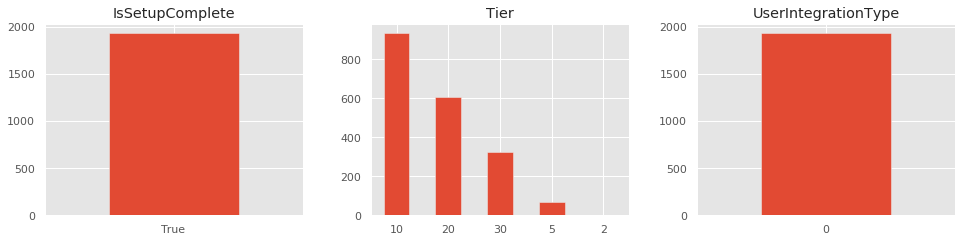

In [0]:
# categorical_features = ["IsSetupComplete", Tier", "UserIntegrationType"]

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, categorical_feature in enumerate(categorical_features):
  df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i], rot=0).set_title(categorical_feature)

fig.tight_layout(pad=3.0)

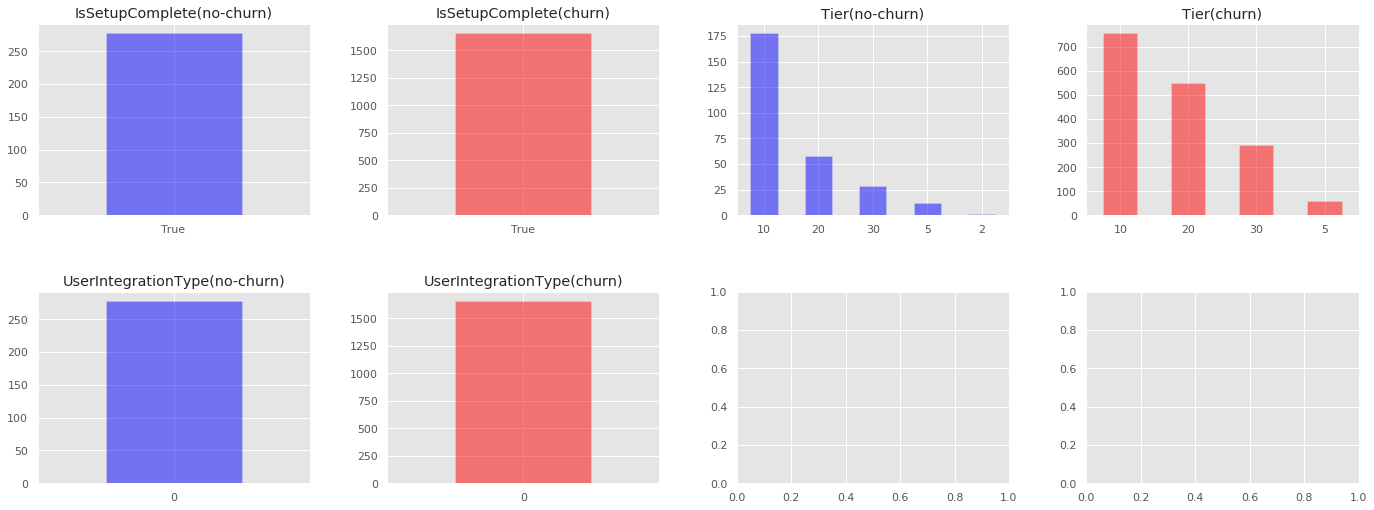

In [0]:
plt.style.use('ggplot')

# 2 row 4 col
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

df[df.Churn == False]['IsSetupComplete'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 0], rot=0).set_title('IsSetupComplete(no-churn)')
df[df.Churn == True]['IsSetupComplete'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 1], rot=0).set_title('IsSetupComplete(churn)')

df[df.Churn == False]['Tier'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 2], rot=0).set_title('Tier(no-churn)')
df[df.Churn == True]['Tier'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 3], rot=0).set_title('Tier(churn)')

df[df.Churn == False]['UserIntegrationType'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[1, 0], rot=0).set_title('UserIntegrationType(no-churn)')
df[df.Churn == True]['UserIntegrationType'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[1, 1], rot=0).set_title('UserIntegrationType(churn)')

fig.tight_layout(pad=4.0)


Numerical feature distributions

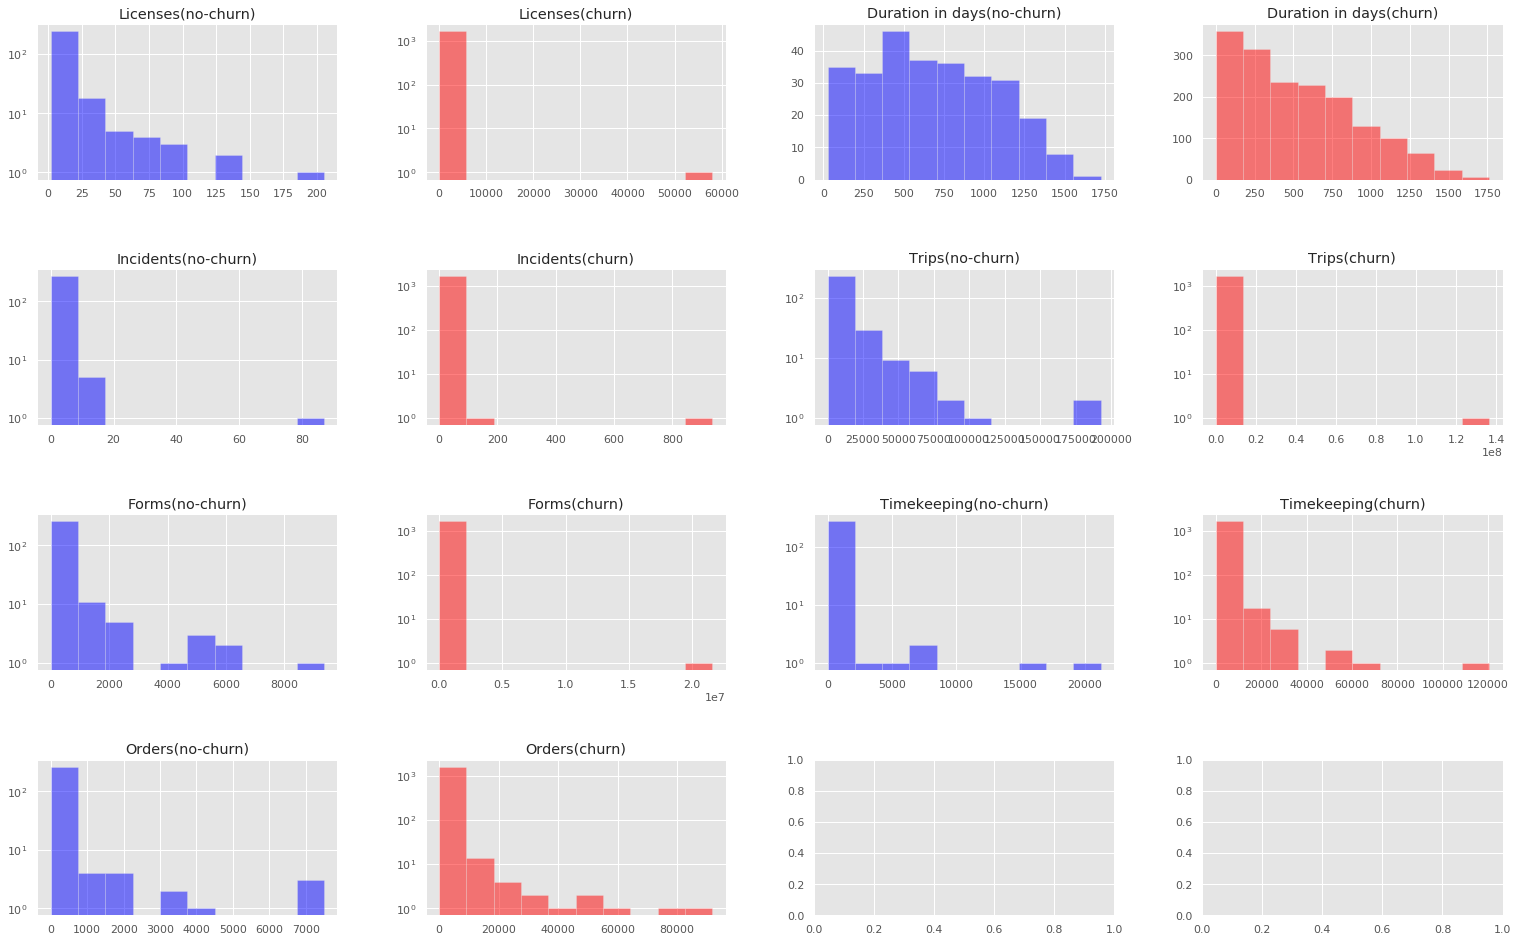

In [0]:
# numerical_features = ["Licenses", "Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

plt.style.use('ggplot')

rows, columns = 4, 4
fig, ax = plt.subplots(rows, columns, figsize=(22, 14))

df[df.Churn == False]["Licenses"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 0]).set_title("Licenses(no-churn)")
df[df.Churn == True]["Licenses"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 1]).set_title("Licenses(churn)")
ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')

df[df.Churn == False]["Duration"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 2]).set_title("Duration in days(no-churn)")
df[df.Churn == True]["Duration"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 3]).set_title("Duration in days(churn)")

df[df.Churn == False]["Incidents"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 0]).set_title("Incidents(no-churn)")
df[df.Churn == True]["Incidents"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 1]).set_title("Incidents(churn)")
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')

df[df.Churn == False]["Trips"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 2]).set_title("Trips(no-churn)")
df[df.Churn == True]["Trips"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 3]).set_title("Trips(churn)")
ax[1, 2].set_yscale('log')
ax[1, 3].set_yscale('log')

df[df.Churn == False]["Forms"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 0]).set_title("Forms(no-churn)")
df[df.Churn == True]["Forms"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 1]).set_title("Forms(churn)")
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')

df[df.Churn == False]["Timekeeping"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 2]).set_title("Timekeeping(no-churn)")
df[df.Churn == True]["Timekeeping"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 3]).set_title("Timekeeping(churn)")
ax[2, 2].set_yscale('log')
ax[2, 3].set_yscale('log')

df[df.Churn == False]["Orders"].hist(bins=10, color="blue", alpha=0.5, ax=ax[3, 0]).set_title("Orders(no-churn)")
df[df.Churn == True]["Orders"].hist(bins=10, color="red", alpha=0.5, ax=ax[3, 1]).set_title("Orders(churn)")
ax[3, 0].set_yscale('log')
ax[3, 1].set_yscale('log')

fig.tight_layout(pad=4.0)

Correlation Matrix and Heatmap

In [0]:
df = df[categorical_features + [target] + numerical_features]

df.corr()

,IsSetupComplete,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
IsSetupComplete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tier,NaN,1.000000,NaN,0.125058,-0.014548,0.049917,-0.003294,-0.018338,-0.014822,0.134999,0.140130
UserIntegrationType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Churn,NaN,0.125058,NaN,1.000000,0.016423,-0.135540,0.041840,0.010174,0.010563,0.044636,0.038256
Licenses,NaN,-0.014548,NaN,0.016423,1.000000,0.052534,0.886531,0.998233,0.997755,0.016547,0.003176
Duration,NaN,0.049917,NaN,-0.135540,0.052534,1.000000,0.137038,0.045067,0.043938,0.112652,0.067717
Incidents,NaN,-0.003294,NaN,0.041840,0.886531,0.137038,1.000000,0.882967,0.881079,0.046461,0.050018
Trips,NaN,-0.018338,NaN,0.010174,0.998233,0.045067,0.882967,1.000000,0.999546,0.002974,-0.000817
Forms,NaN,-0.014822,NaN,0.010563,0.997755,0.043938,0.881079,0.999546,1.000000,0.003696,-0.000366
Timekeeping,NaN,0.134999,NaN,0.044636,0.016547,0.112652,0.046461,0.002974,0.003696,1.000000,0.084082


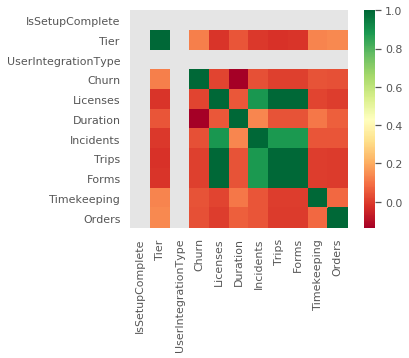

In [0]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

Create dummy variables for categorical variables

In [0]:
# cat_vars=['IsSetupComplete','Tier','UserIntegrationType']
# for var in cat_vars:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(df[var], prefix=var)
#     df1=df.join(cat_list)
#     df=df1
    
# df_vars=df.columns.values.tolist()
# to_keep=[i for i in df_vars if i not in cat_vars]
# df_final=df[to_keep]
# df_final.columns.values

In [0]:
df_final = df
df_final.head()

,IsSetupComplete,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
0,True,10,0,1,9,233,85,2819,0,66,0
1,True,30,0,1,43,227,0,0,5,4,624
2,True,10,0,1,8,211,0,922,0,0,0
3,True,10,0,1,34,657,0,16683,2,0,6
7,True,10,0,1,19,931,0,1709,0,69,2


**Training**

In [0]:
# --- training with SMOTE ---
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks

X = df_final.loc[:, df_final.columns != 'Churn']
y = df_final.loc[:, df_final.columns == 'Churn']

# SMOTENC is the only one that handles categorical values.
oversample = SMOTENC(k_neighbors=1, random_state=0, sampling_strategy=0.3, categorical_features=[0,1,2])
# oversample = SMOTENC(random_state=0, categorical_features=[0,1,2])

# under-sample
undersample = TomekLinks()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
columns = X_train.columns

if over_sample:
  data_X, data_y = oversample.fit_sample(X_train, y_train)
  X_train = pd.DataFrame(data=data_X,columns=columns )
  y_train = pd.DataFrame(data=data_y,columns=['Churn'])
  
if under_sample:
  data_X, data_y = undersample.fit_sample(X_train, y_train)
  X_train = pd.DataFrame(data=data_X,columns=columns )
  y_train = pd.DataFrame(data=data_y,columns=['Churn'])

# we can Check the numbers of our data
print("length of data is ",len(X_train))
print("Number of no churn in  data",len(y_train[y_train['Churn']==0]))
print("Number of churn",len(y_train[y_train['Churn']==1]))
print("Proportion of no churn data in data is ",len(y_train[y_train['Churn']==0])/len(X_train))
print("Proportion of churn data in data is ",len(y_train[y_train['Churn']==1])/len(X_train))


length of data is 1452
Number of no churn in data 208
Number of churn 1244
Proportion of no churn data in data is 0.14325068870523416
Proportion of churn data in data is 0.8567493112947658

In [0]:
X.head()

,IsSetupComplete,Tier,UserIntegrationType,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
0,True,10,0,9,233,85,2819,0,66,0
1,True,30,0,43,227,0,0,5,4,624
2,True,10,0,8,211,0,922,0,0,0
3,True,10,0,34,657,0,16683,2,0,6
7,True,10,0,19,931,0,1709,0,69,2


In [0]:
# training the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

clf = XGBClassifier(random_state=42) # tree_method=hist or gpu_hist for faster computation

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

param_grid = {
    # complexity
    "max_depth": randint(3, 10), # default 6
    "min_child_weight": uniform(0.5, 2),
    "gamma": uniform(0, 1),
    "n_estimators": randint(100, 150), # default 100
    # noise
    "learning_rate": uniform(0.03, 0.3), # default 0.1    
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.7, 0.3),
    # imbalance
    "scale_pos_weight": uniform(0.3, 0.7)
}

tree_cv = RandomizedSearchCV(clf, param_distributions=param_grid, random_state=42, n_iter=200, cv=cv, return_train_score=True, scoring='roc_auc')

# param_grid = {
#     # complexity
#     "max_depth": [6],
#     "min_child_weight": [1],
#     "gamma": [0.7],
#     "n_estimators": [120],
#     # noise
#     "learning_rate": [0.03],    
#     "subsample": [0.8],
#     "colsample_bytree": [0.9],
#     # imbalance
#     "scale_pos_weight": [0.8]
# }

# tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='roc_auc')

tree_cv.fit(X_train, np.ravel(y_train))

pred = tree_cv.predict(X_test)

print("Tuned XGBoost: {}".format(tree_cv.best_params_))
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(tree_cv.score(X_test, y_test)))

Tuned XGBoost: {'colsample_bytree': 0.9, 'gamma': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 120, 'scale_pos_weight': 0.8, 'subsample': 0.8}
Accuracy of XGBoost classifier on test set: 0.81

**Testing **

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score

# print(classification_report(y_test, pred, labels=np.unique(pred), zero_division=0))
print(classification_report(y_test, pred))

precision recall f1-score support

 0 0.64 0.26 0.37 70
 1 0.89 0.98 0.93 414

 accuracy 0.87 484
 macro avg 0.76 0.62 0.65 484
weighted avg 0.85 0.87 0.85 484

**Model Interpretation**

In [0]:
model = tree_cv.best_estimator_
class_names = [str(el) for el in model.classes_]
feature_names = categorical_features + numerical_features

print(model)
print("Feature names: {}".format(feature_names))
print("Class names: {}".format(class_names))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=0.9, gamma=0.7, gpu_id=-1,
 importance_type='gain', interaction_constraints='',
 learning_rate=0.03, max_delta_step=0, max_depth=6,
 min_child_weight=1, missing=nan, monotone_constraints='()',
 n_estimators=120, n_jobs=0, num_parallel_tree=1, random_state=42,
 reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, subsample=0.8,
 tree_method='exact', validate_parameters=1, verbosity=None)
Feature names: ['IsSetupComplete', 'Tier', 'UserIntegrationType', 'Licenses', 'Duration', 'Incidents', 'Trips', 'Forms', 'Timekeeping', 'Orders']
Class names: ['0', '1']

The following feature importances are not exactly same as SHAP. Be careful in their interpretation.    
The detailed reference can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=importance_type). A good review can be found [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7).  

**"gain" types are most important: total gain & average gain across all trees.**

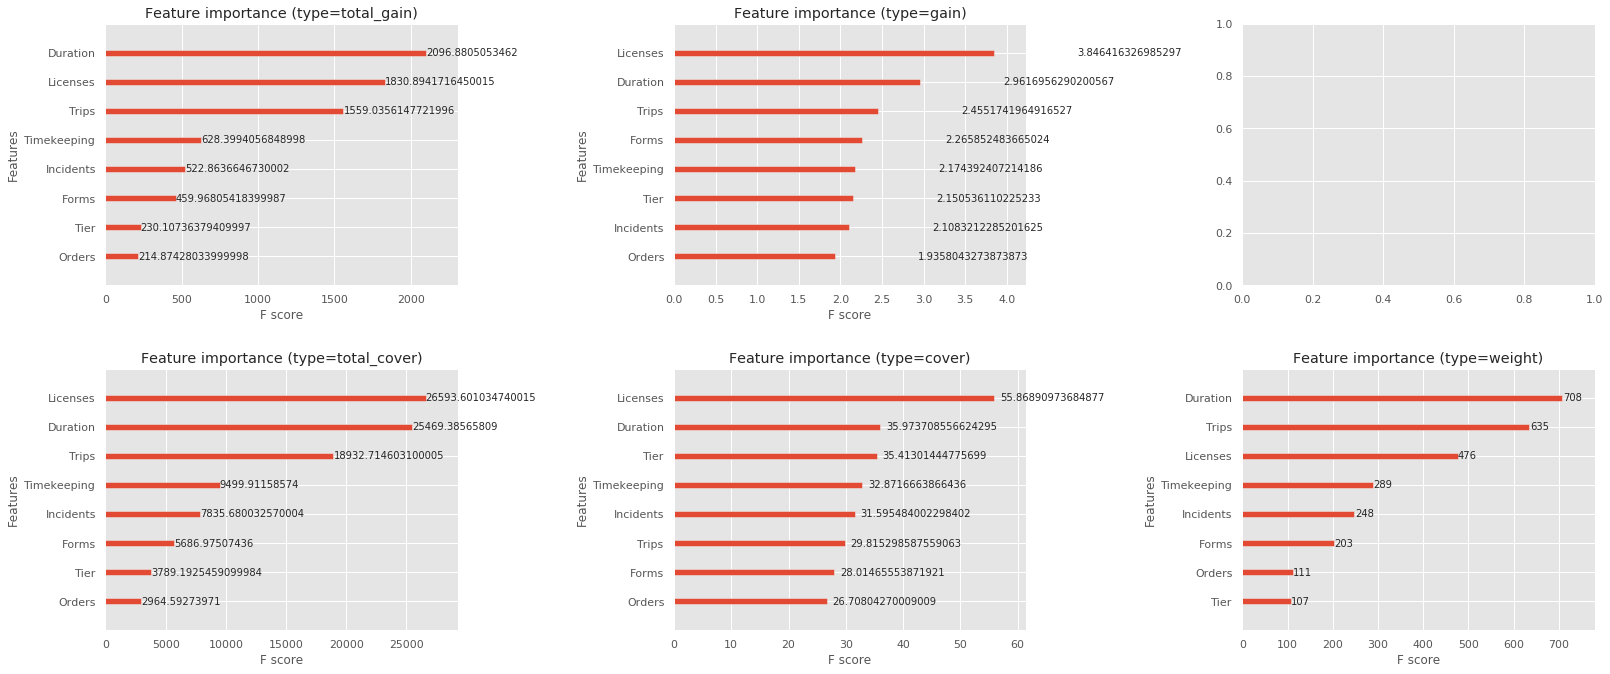

In [0]:
from xgboost import plot_importance

plt.style.use('ggplot')

fig, ax = plt.subplots(2, 3, figsize=(23, 10))

plot_importance(model, importance_type="total_gain", ax=ax[0,0])
ax[0,0].set_title('Feature importance (type=total_gain)')

plot_importance(model, importance_type="gain", ax=ax[0,1])
ax[0,1].set_title('Feature importance (type=gain)')

plot_importance(model, importance_type="total_cover", ax=ax[1,0])
ax[1,0].set_title('Feature importance (type=total_cover)')

plot_importance(model, importance_type="cover", ax=ax[1,1])
ax[1,1].set_title('Feature importance (type=cover)')

plot_importance(model, importance_type="weight", ax=ax[1,2])
ax[1,2].set_title('Feature importance (type=weight)')

fig.tight_layout(pad=3.0)